#Librerias:

In [1]:
!pip install -q mediapy

In [ ]:
!pip install tensorflow

In [ ]:
!pip install ultralytics

In [ ]:
!pip install supervision

In [ ]:
!pip install timm
!clear

In [6]:
import mediapy as media
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from PIL import Image,ImageDraw
import numpy as np
import mediapy as media
import cv2
from ultralytics import YOLO
from IPython.display import Image as image_show
from typing import Callable
import supervision as sv
from transformers import DetrFeatureExtractor, DetrForSegmentation
from transformers.models.detr.feature_extraction_detr import rgb_to_id
import io
import torch
import itertools
import timm

#Ejercicio 8:

In [7]:
#Esto convierte el video a un formato más liviano de trabajo
!ffmpeg -y -i video_pato.mp4 -vf "scale=600:-1" -an -t 30 video_pato.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [8]:
video = media.read_video('video_pato.mp4') #verificamos que el video corra correctamente
media.show_video(video)

In [9]:
def process_video1(filename_in, filename_out, process_func, max_time=10, **kwargs):

    with media.VideoReader(filename_in) as r:    # abro el video de entrada para lectura

        with media.VideoWriter(filename_out, shape=r.shape, fps=r.fps, bps=r.bps) as w:  # Creo un archivo de video de salida
            count = 0  # contador de fotogramas
            prev_image = None  # imagen previa

            # Iterar sobre cada imagen (fotograma) del video
            for image in r:
                image = media.to_uint8(image)  # Convertir la imagen a formato flotante

                # Procesar la imagen utilizando la función dada
                processed_image = process_func(image, **kwargs)

                if processed_image is not None:
                  # Añadir la imagen procesada al video de salida
                  w.add_image(processed_image)

                # Incrementar el contador de fotogramas
                count += 1

                # Detener el proceso si se alcanza el tiempo máximo
                if count >= max_time * r.fps:
                    break

##EfficientNet

In [10]:
# Cargar el modelo preentrenado EfficientNetB0
model = EfficientNetB0(weights='imagenet')

def classify_image(img):
    # Si se proporciona una ruta de archivo, cargar la imagen
    if isinstance(img, str):
        img = Image.open(img)
    # Asegurarse de que estás trabajando con una copia del array
    img_array = np.array(img.copy())

    # Redimensionar la imagen
    img_array = cv2.resize(img_array, (224, 224))  # Tamaño de entrada para EfficientNetB0

    # Convertir la imagen a un array y procesarla
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Realizar la predicción con el modelo
    predictions = model.predict(img_array)

    # Decodificar y retornar las predicciones
    return decode_predictions(predictions, top=1)[0]

In [11]:
def predict_object(image_path):

  predictions = classify_image(image_path)

  # Mostrar las predicciones
  for i, (imagenet_id, label, score) in enumerate(predictions):
      print(f"{i + 1}: {label} ({score:.2f})")

In [12]:
file_in = '/content/video_pato.mp4'
file_out = '/content/video_pato_procesado.mp4'

# Llamar a la función para procesar el video
process_video1(file_in, file_out, predict_object)

1/1 [==============================] - 2s 2s/step
1: pelican (0.71)
1/1 [==============================] - 0s 95ms/step
1: pelican (0.65)
1/1 [==============================] - 0s 100ms/step
1: pelican (0.53)
1/1 [==============================] - 0s 91ms/step
1: pelican (0.46)
1/1 [==============================] - 0s 100ms/step
1: pelican (0.46)
1/1 [==============================] - 0s 90ms/step
1: pelican (0.30)
1/1 [==============================] - 0s 83ms/step
1: pelican (0.27)
1/1 [==============================] - 0s 98ms/step
1: pelican (0.46)
1/1 [==============================] - 0s 91ms/step
1: pelican (0.43)
1/1 [==============================] - 0s 93ms/step
1: pelican (0.45)
1/1 [==============================] - 0s 106ms/step
1: pelican (0.40)
1/1 [==============================] - 0s 90ms/step
1: pelican (0.37)
1/1 [==============================] - 0s 106ms/step
1: pelican (0.30)
1/1 [==============================] - 0s 185ms/step
1: pelican (0.38)
1/1 [============

##YOLO

In [13]:
# Load the pre-trained YOLOv8 model
model_YOLO = YOLO('yolov8n')  # This will automatically download the model weights

In [ ]:
# Train the model using the 'coco128.yaml' dataset for 3 epochs
model_YOLO.train(data='coco128.yaml', epochs=3)

In [15]:
# Definir rutas de los videos de entrada y salida, y el nombre del modelo
source_path = '/content/video_pato.mp4'
target_path = '/content/video_pato_procesado.mp4' # Ruta donde se guardará el video con seguimiento de objetos

# Inicializar el modelo de detección y el rastreador de objetos
#model = YOLO(model_YOLO)  # Cargar el modelo de YOLO
tracker = sv.ByteTrack()  # Inicializar ByteTrack para el seguimiento de objetos

# Inicializar los anotadores para las cajas delimitadoras y las etiquetas
bounding_box_annotator = sv.BoundingBoxAnnotator()  # Para dibujar cajas delimitadoras
label_annotator = sv.LabelAnnotator()  # Para dibujar etiquetas (IDs de seguimiento)

# Definir la función de callback que procesa cada frame
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    results = model_YOLO(frame)[0]  # Detectar objetos en el frame actual con YOLO
    detections = sv.Detections.from_ultralytics(results)  # Convertir resultados a formato de supervision
    detections = tracker.update_with_detections(detections)  # Actualizar el estado del rastreador con las detecciones

    labels = [f"#{tracker_id}" for tracker_id in detections.tracker_id]  # Crear etiquetas con los IDs de seguimiento

    # Anotar el frame con bounding boxes y etiquetas
    annotated_frame = bounding_box_annotator.annotate(
        scene=frame.copy(), detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels)
    return annotated_frame  # Devolver el frame anotado

# Procesar el video: leer, aplicar callback a cada frame y guardar el resultado
# Procesar el video
sv.process_video(
    source_path=source_path,
    target_path=target_path,
    callback=callback
)


0: 384x640 5 birds, 333.0ms
Speed: 2.7ms preprocess, 333.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 birds, 235.9ms
Speed: 2.2ms preprocess, 235.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 birds, 232.8ms
Speed: 2.3ms preprocess, 232.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 birds, 232.7ms
Speed: 2.4ms preprocess, 232.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 birds, 230.8ms
Speed: 2.3ms preprocess, 230.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 birds, 237.3ms
Speed: 2.3ms preprocess, 237.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 birds, 247.4ms
Speed: 2.8ms preprocess, 247.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 birds, 237.6ms
Speed: 2.4ms preprocess, 237.6ms inference, 2.1ms postprocess per image at shape (

In [16]:
def process_YOLO(image):
    # Realizar inferencia
    results = model_YOLO(image)

    # Imagen a devolver
    annotated_frame = image

    # Iterar sobre las bounding boxes obtenidas
    for box in results[0].boxes:
        # Extraer los datos de la caja del tensor
        x1, y1, x2, y2, confidence, cls = box.data[0]

        # Obtener el nombre de la clase
        class_name = model_YOLO.names[int(cls)]

        # Si la clase detectada es 'bicycle', crear bounding box
        if class_name == 'flamingo':
            # Imprimir los resultados en un formato legible
            print(f"Confianza de la clase: {confidence:.2f}")

            # Dibujar bounding box en el marco anotado
            annotated_frame = cv2.rectangle(annotated_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

            # Agregar etiqueta de la clase al bounding box
            cv2.putText(annotated_frame, class_name, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return annotated_frame

In [17]:
file_in = '/content/video_pato.mp4'
file_out = '/content/video_pato_procesado.mp4'

# Llamar a la función para procesar el video
process_video1(file_in, file_out, process_YOLO)
# Mostrar el video resultante
media.show_video(media.read_video(file_out), fps=30)


0: 384x640 3 birds, 235.9ms
Speed: 5.4ms preprocess, 235.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 birds, 164.8ms
Speed: 2.9ms preprocess, 164.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 birds, 164.0ms
Speed: 2.4ms preprocess, 164.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 birds, 167.4ms
Speed: 3.0ms preprocess, 167.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 birds, 164.1ms
Speed: 2.6ms preprocess, 164.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 birds, 170.1ms
Speed: 3.6ms preprocess, 170.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 birds, 157.2ms
Speed: 2.3ms preprocess, 157.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 birds, 155.9ms
Speed: 2.6ms preprocess, 155.9ms inference, 1.4ms postprocess per image at shape (

#Ejercicio 9

##Edge Based Method

In [18]:
# Cargar la imagen
ruta_img = 'animales_solapados.png'
image = cv2.imread(ruta_img , cv2.IMREAD_GRAYSCALE)

# Aplicar suavizado Gaussiano
blurred = cv2.GaussianBlur(image, (3, 3), 0)

# Detección de bordes usando el gradiente Sobel
grad_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

# Magnitud del gradiente
gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

# Dirección del gradiente
gradient_direction = np.arctan2(grad_y, grad_x)

# Umbral de Canny
lower_threshold = 30
upper_threshold = 100
edges = cv2.Canny(np.uint8(gradient_magnitude), lower_threshold, upper_threshold)

# Aplicar Laplaciano para detectar bordes adicionales
laplacian = cv2.Laplacian(blurred, cv2.CV_64F)

# Umbral para convertir la imagen de Laplaciano a imagen binaria
laplacian_edges = np.uint8(np.absolute(laplacian) > 20)

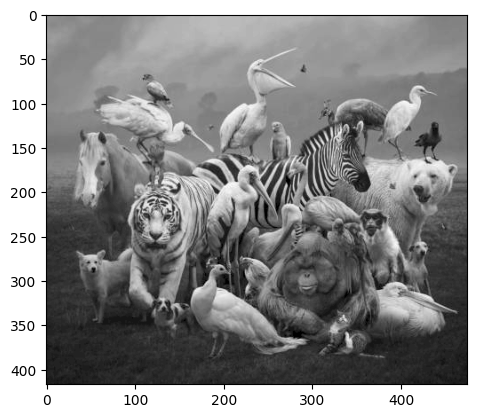

In [19]:
plt.imshow(image, cmap='gray')

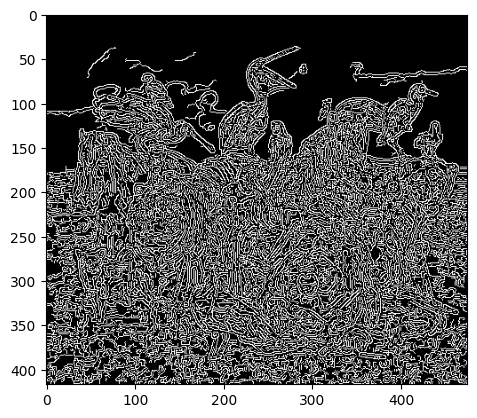

In [20]:
plt.imshow(edges, cmap='gray')

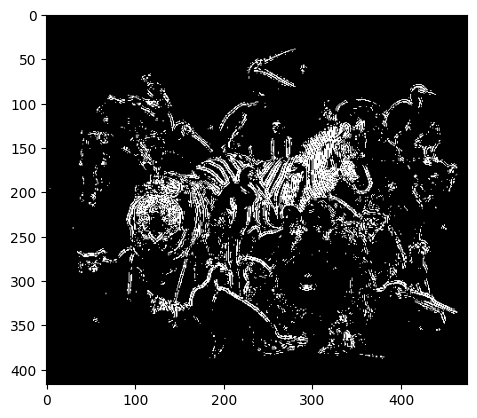

In [21]:
plt.imshow(laplacian_edges, cmap='gray')

##Watershed

In [22]:
# Cargar la imagen
image = cv2.imread(ruta_img)

# Convertir la imagen a escala de grises
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar umbralización para segmentar la imagen
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Eliminar ruido con una operación morfológica de apertura
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Distinguir los diferentes objetos con la transformada de distancia
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Encontrar el área de fondo
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(opening, sure_fg)

# Etiquetar los objetos conectados
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Convertir la imagen original a formato de 8 bits sin signo (CV_8U)
image_rgb = cv2.convertScaleAbs(image)

# Aplicar la segmentación de Watershed
markers = cv2.watershed(image_rgb, markers)
image_rgb[markers == -1] = [0,0,255]

# Crear una imagen solo con los bordes
border_image = np.zeros_like(image)
border_image[markers == -1] = [255, 255, 255]

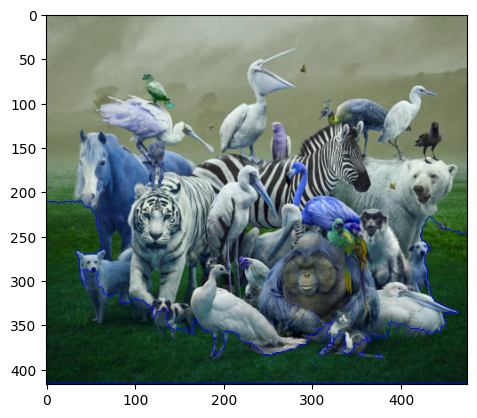

In [23]:
plt.imshow(image_rgb)

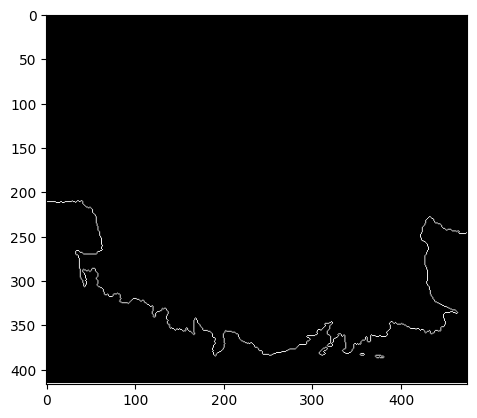

In [24]:
plt.imshow(border_image)

##Panoptic Segmentation

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
`post_process_panoptic is deprecated and will be removed in v5 o

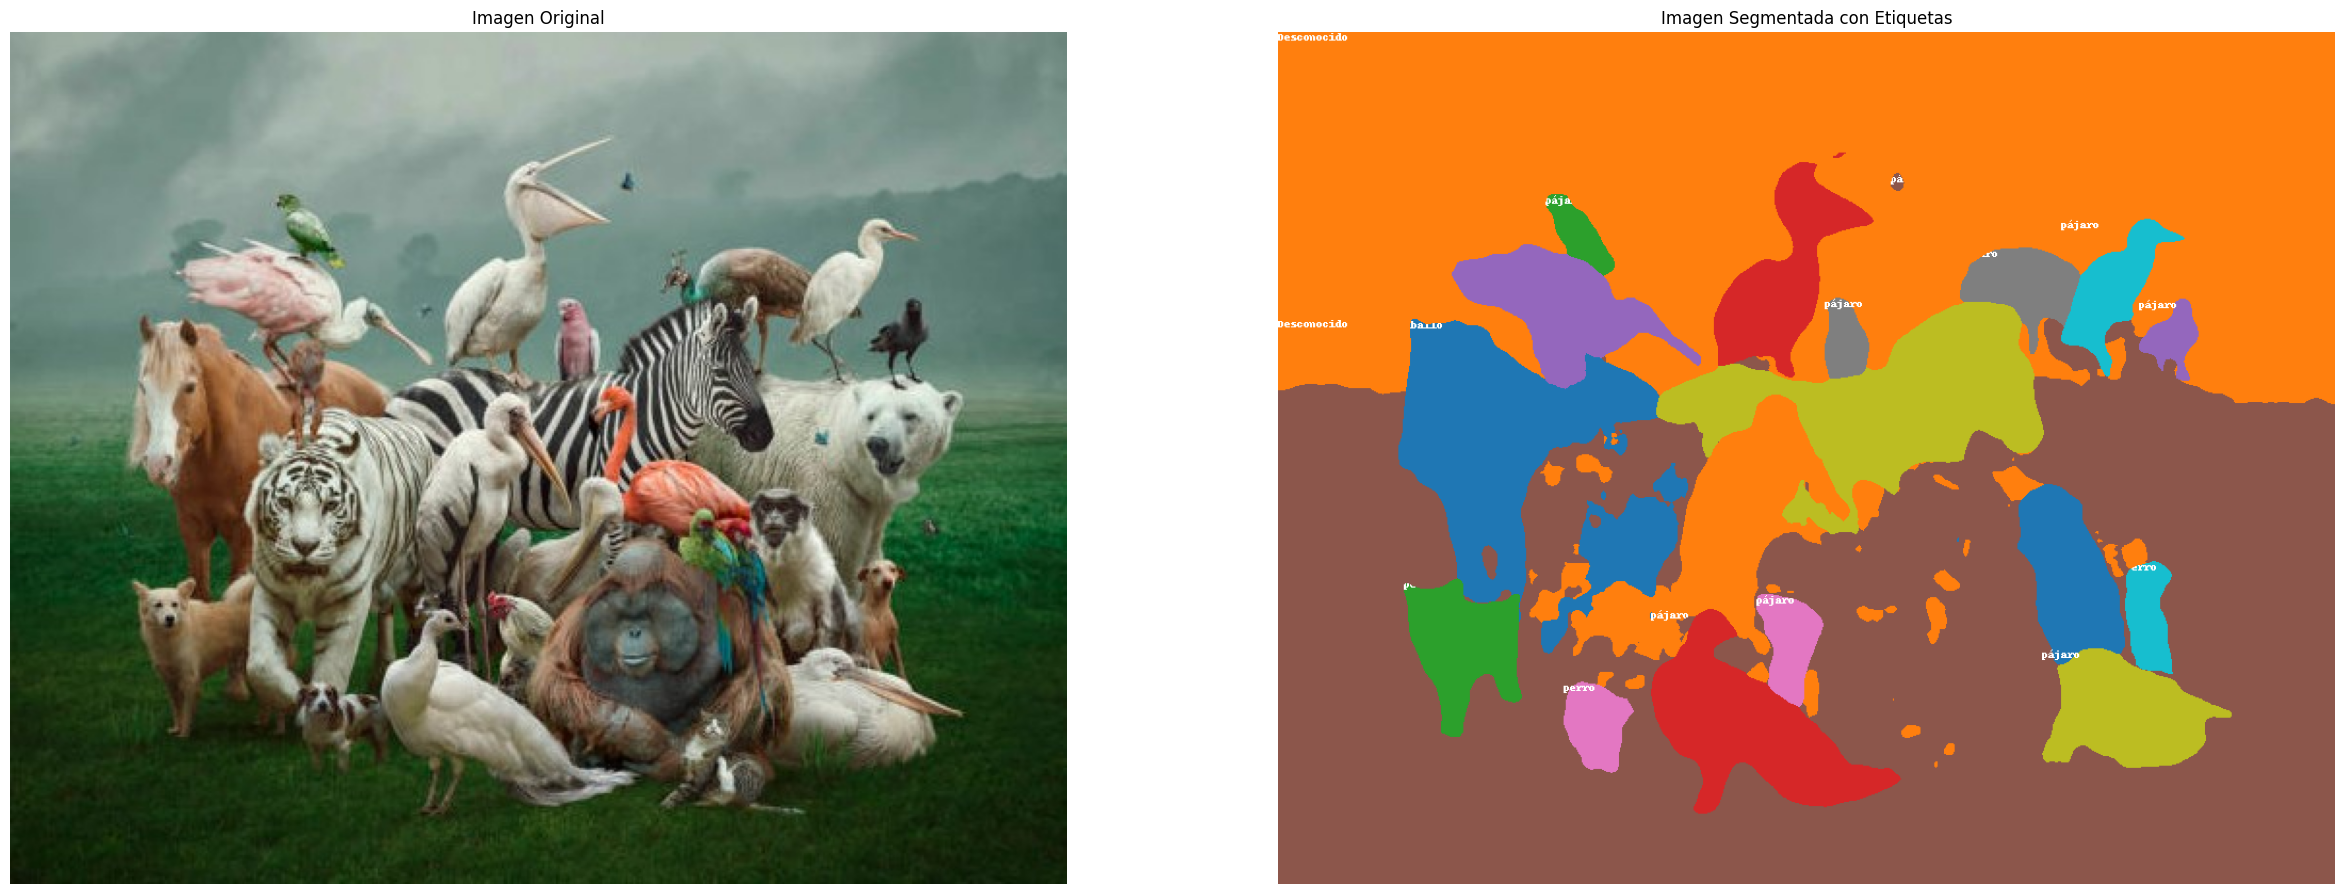

In [27]:
# Cargar la imagen
ruta_img1 = 'animales.jpg'
image = Image.open(ruta_img1)

# Cargar el modelo y el extractor de características
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")
model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")

# Preparar la imagen para el modelo
inputs = feature_extractor(images=image, return_tensors="pt")

# Paso forward
outputs = model(**inputs)

# Postprocesamiento
processed_sizes = torch.as_tensor(inputs["pixel_values"].shape[-2:]).unsqueeze(0)
result = feature_extractor.post_process_panoptic(outputs, processed_sizes, threshold=0.85)[0]

# Convertir la segmentación a numpy
panoptic_seg = Image.open(io.BytesIO(result["png_string"]))
panoptic_seg = np.array(panoptic_seg, dtype=np.uint8)
panoptic_seg_id = rgb_to_id(panoptic_seg)

# Preparar la paleta de colores
palette = itertools.cycle(sns.color_palette())

# Crear la imagen segmentada
segmented_image = Image.fromarray(np.zeros_like(panoptic_seg, dtype=np.uint8))
draw = ImageDraw.Draw(segmented_image)

# Añadimos un mapeo manual de los IDs de las categorías a los nombres, basado en las clases comunes de COCO
COCO_LABELS = {
    1: 'persona', 2: 'bicicleta', 3: 'coche', 4: 'motocicleta', 5: 'avión',
    6: 'autobús', 7: 'tren', 8: 'camión', 9: 'barco', 10: 'semáforo',
    11: 'hidrante', 13: 'señal de stop', 14: 'parquímetro', 15: 'banco', 16: 'pájaro',
    17: 'gato', 18: 'perro', 19: 'caballo', 20: 'oveja', 21: 'vaca',
    22: 'elefante', 23: 'oso', 24: 'cebra', 25: 'jirafa', 27: 'mochila',
    28: 'paraguas', 31: 'bolso de mano', 32: 'corbata', 33: 'maleta', 34: 'frisbee',
    36: 'tabla de snowboard', 37: 'pelota deportiva', 38: 'cometa', 39: 'bate de béisbol',
    40: 'guante de béisbol', 41: 'patineta', 42: 'tabla de surf', 43: 'raqueta de tenis',
    44: 'botella', 46: 'plato de vino', 47: 'taza', 48: 'tenedor', 49: 'cuchillo',
    50: 'cuchara', 51: 'tazón', 52: 'banana', 53: 'manzana', 54: 'sándwich',
    55: 'naranja', 56: 'brócoli', 57: 'zanahoria', 58: 'perrito caliente', 59: 'pizza',
    60: 'donut', 61: 'pastel', 62: 'silla', 63: 'sofá', 64: 'maceta', 65: 'cama',
    67: 'mesa de comedor', 70: 'inodoro', 72: 'TV', 73: 'computadora portátil', 74: 'ratón',
    75: 'control remoto', 76: 'teclado', 77: 'teléfono celular', 78: 'microondas',
    79: 'horno', 80: 'tostadora', 81: 'fregadero', 82: 'refrigerador', 84: 'libro',
    85: 'reloj', 86: 'florero', 87: 'tijeras', 88: 'oso de peluche', 89: 'secador de pelo',
    90: 'cepillo de dientes',
}

# Ajusta el bucle para dibujar segmentos y etiquetas correctamente
for segment_info in result["segments_info"]:
    class_id = segment_info["category_id"]
    class_name = COCO_LABELS.get(class_id, 'Desconocido')  # 'Desconocido' si el ID no está en el diccionario
    id = segment_info["id"]

    # Generar la máscara para este segmento específico
    mask = panoptic_seg_id == id
    color = np.array(next(palette)) * 255  # Convertir el color a un array de numpy adecuado

    # Convertir la máscara a una imagen de PIL para usarla como máscara en 'paste'
    mask_image = Image.fromarray((mask * 255).astype(np.uint8))

    # Crear una imagen del color del segmento que tenga las dimensiones correctas
    color_image = Image.new("RGB", segmented_image.size, color=tuple(color.astype(int)))

    # Pegar usando la máscara para aplicar solo este segmento
    segmented_image.paste(color_image, (0,0), mask=mask_image)

    # Dibujar el nombre de la clase en la posición inicial del segmento
    draw = ImageDraw.Draw(segmented_image)
    where = np.where(mask)
    if where[0].size > 0 and where[1].size > 0:
        x, y = np.min(where[1]), np.min(where[0])
        draw.text((x, y), class_name, fill='white')

# Mostrar la imagen original y la segmentada
plt.figure(figsize=(30, 15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Imagen Segmentada con Etiquetas')
plt.axis('off')

plt.show()